In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./models/')

from cond_CFM import CNF

import numpy as np
import os
from tqdm import tqdm
from typing import *
from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout

from matplotlib import pyplot as plt

from jet_dataset import JetDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#######################
### Define the data ###
#######################

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

dataset = JetDataset("./jet_data",'train', del_context=dont_use)
dataset_val = JetDataset("./jet_data",'val', del_context=dont_use)

In [4]:
save_dir = './data/CFM_VIB_sampling_corrected_k100_jets6/' #'./data/CFM_jets6/' #
#save_dir = './data/CFM_VIB_sampling_corrected_k100_jets7_lrdec0.9999/'

if 'VIB' in save_dir:
    model = CNF(1, conds = dataset.features.shape[1], n_nodes=[64] * 3, layer = LinearFlipout).to(device)
    model.load_state_dict(torch.load(save_dir + f"model_4000.pth"))
    n_stat = 11

    for layer in model.modules():
        if isinstance(layer, LinearFlipout):
            layer._dnn_to_bnn_flag = True
            layer.auto_sample = False 
            layer.sample_weights()
            
    def sample_new_weights(model, n):
        for layer in model.modules():
            if isinstance(layer, LinearFlipout):
                layer.sample_weights()
        return model
    
else:
    path_add_AdamMCMC = '/AdamMCMC_models_lambda50/'
    m_list_dir = save_dir + path_add_AdamMCMC

    n_m_list = len([l for l in os.listdir(m_list_dir) if 'model' in l])
    m_list = [f'AdamMCMC_model_{n}.pth' for n in range(n_m_list) if n%100==0]
    n_stat = len(m_list)+1

    model = CNF(1, conds = dataset.features.shape[1], n_nodes=[64] * 3).to(device)
    model.load_state_dict(torch.load(save_dir + f"model_4000.pth"))
    
    def sample_new_weights(model, n):
        model.load_state_dict(torch.load(m_list_dir + m_list[n]))
        return model

In [5]:
bins = np.linspace(0,1,21)
alpha_quant = np.linspace(0,1,50)

In [6]:
np.random.seed(231957)
perm = np.random.permutation(len(dataset_val.features))
n_data = 10000

dataset_val.features = dataset_val.features[perm[:n_data]]
dataset_val.target = dataset_val.target[perm[:n_data]]

In [7]:
n_stat_alea = 1000
batchsize = 1000
n_points = len(dataset_val.features)
eval = True

if eval:
    in_quantile = np.zeros((n_points, len(alpha_quant), n_stat))
    acc = np.zeros((n_points, n_stat))
    err_diff = np.zeros((n_points))
    err_diff_hist = np.zeros((n_points))

    for i in tqdm(range(n_points//batchsize)):
        c = torch.Tensor(dataset_val.features[i*batchsize:(i+1)*batchsize]).to(device)
        t = torch.sigmoid(torch.Tensor(dataset_val.target[i*batchsize:(i+1)*batchsize])*20).numpy()

        z = torch.randn(n_stat_alea*batchsize, 1).to(device)
        
        x_gens = np.zeros((n_stat, batchsize, n_stat_alea))
        for n in range(n_stat):
            if n != 0:
                sample_new_weights(model, n-1)

            x_gen = model.decode(z, cond=c.repeat_interleave(n_stat_alea, dim=0))
            x_gen = torch.sigmoid(x_gen*20).detach().cpu().numpy().reshape(batchsize, n_stat_alea)
            x_gens[n] = x_gen

            in_quantile[i*batchsize:(i+1)*batchsize, :, n] = np.quantile(x_gen, alpha_quant, axis=1).T >= t #without the sigmiod? same results
            tresh = 0.5
            is_top =c[:,0].detach().cpu().numpy()
            acc[i*batchsize:(i+1)*batchsize, n] = (is_top==-1.).astype(float) + is_top*((x_gen > 0.5).sum(1)/n_stat_alea)

        err_diff[i*batchsize:(i+1)*batchsize] = np.mean(x_gens.max(0)-x_gens.min(0), 1)

        for j in range(len(c)):
            hists = []
            for n2 in range(n_stat):
                hist, _ = np.histogram(x_gens[n2, j], bins = bins)
                hists.append(hist)
                
            hists = np.array(hists)
            hist_max = hists.max(0)
            hist_min = hists.min(0)
            err_diff_hist[i*batchsize+j] = np.mean(hist_max-hist_min)

    empirical_coverage = np.sum(in_quantile, axis = 0)/n_points


    with open(save_dir+'empirical_coverage_ep3000.npy', 'wb') as f:
        np.save(f, empirical_coverage)
    with open(save_dir+'acc_ep3000.npy', 'wb') as f:
        np.save(f, acc)
    with open(save_dir+'err_diff_ep3000.npy', 'wb') as f:
        np.save(f, err_diff)
    with open(save_dir+'err_diff_hist_ep3000.npy', 'wb') as f:
        np.save(f, err_diff_hist)
else:
    with open(save_dir+'empirical_coverage.npy', 'rb') as f:
        empirical_coverage = np.load(f)
    with open(save_dir+'acc.npy', 'rb') as f:
        acc = np.load(f)
    with open(save_dir+'err_diff.npy', 'rb') as f:
        err_diff = np.load(f)
    with open(save_dir+'err_diff_hist.npy', 'rb') as f:
        err_diff_hist = np.load(f)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [52:27<00:00, 314.72s/it]


Text(0.5, 0, 'nominal coverage')

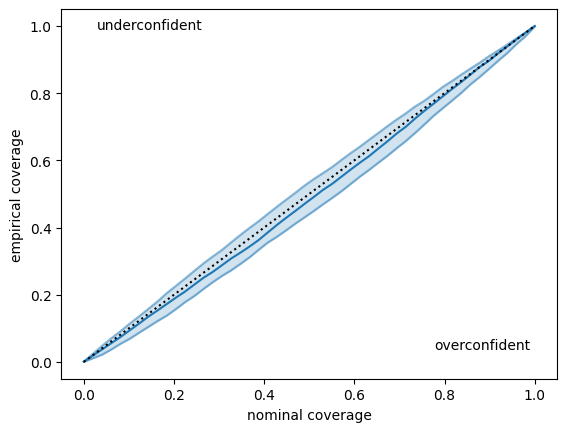

In [12]:
plt.plot(alpha_quant, empirical_coverage[:,0], color = 'C0')
plt.plot(alpha_quant, empirical_coverage.min(1), color = 'C0', alpha =.5)
plt.plot(alpha_quant, empirical_coverage.max(1), color = 'C0', alpha =.5)
plt.fill_between(alpha_quant, empirical_coverage.max(1), empirical_coverage.min(1),  color = 'C0', alpha =.2)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='black', linestyle = ':')
plt.text(0.03,0.99, 'underconfident')
plt.text(0.99,0.03, 'overconfident', va='bottom', ha='right')
plt.ylabel('empirical coverage')
plt.xlabel('nominal coverage')

<ErrorbarContainer object of 3 artists>

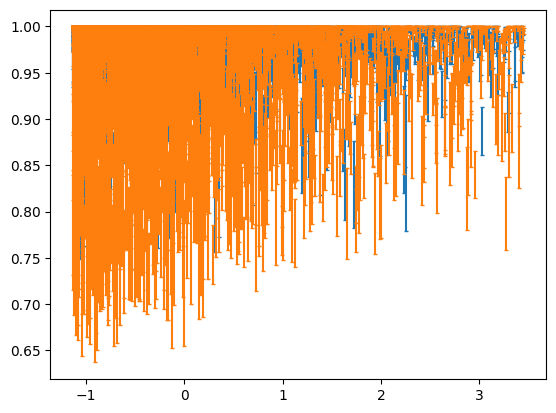

In [9]:
mask = dataset_val.features[:,0] == 1.
plt.errorbar(dataset_val.features[:,1][mask], acc.mean(1)[mask], (acc.mean(1)[mask]-acc.min(1)[mask]+1e-9,acc.max(1)[mask]-acc.mean(1)[mask]+1e-9), 
             linestyle = 'none', capsize = 1.5)

mask = dataset_val.features[:,0] == -1.
plt.errorbar(dataset_val.features[:,1][mask], acc.mean(1)[mask], (acc.mean(1)[mask]-acc.min(1)[mask]+1e-9,acc.max(1)[mask]-acc.mean(1)[mask]+1e-9), 
             linestyle = 'none', capsize = 1.5)

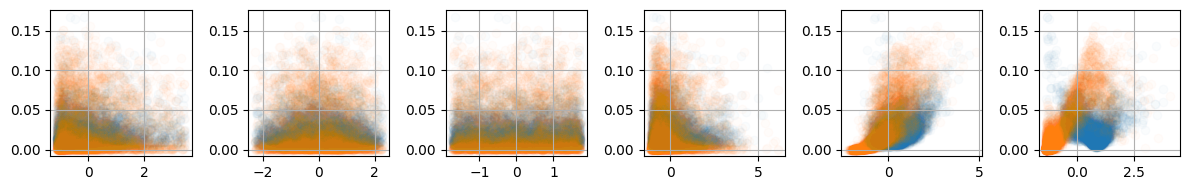

In [10]:
n_plots = dataset_val.features.shape[1]-1
fig, ax = plt.subplots(1, n_plots, figsize=(12,2))
for i in range(n_plots):
    a = ax[i]
    a.grid()

    mask = np.bitwise_and(dataset_val.features[:,0] == 1., acc.mean(1)>0.0)
    a.scatter(dataset_val.features[:,i+1][mask], err_diff[mask], alpha  =.02)

    #a.hist(dataset_val.features[:,i+1][mask], color = 'C0', density = True)

    mask = np.bitwise_and(dataset_val.features[:,0] == -1., acc.mean(1)>0.0)
    a.scatter(dataset_val.features[:,i+1][mask], err_diff[mask], alpha  =.02)
    #a.hist(dataset_val.features[:,i+1][mask], color = 'C1', density = True)

fig.tight_layout()

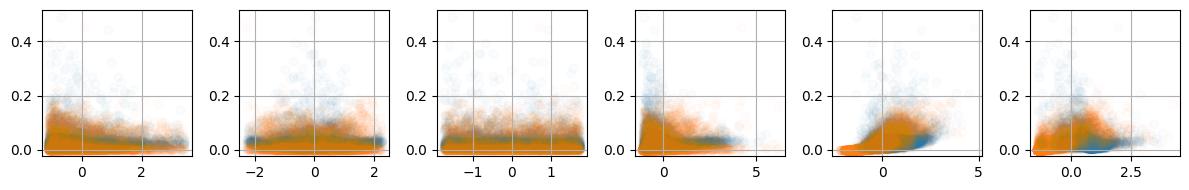

In [11]:
save_dir = './data/CFM_jets6/' 
with open(save_dir+'empirical_coverage.npy', 'rb') as f:
    empirical_coverage = np.load(f)
with open(save_dir+'acc.npy', 'rb') as f:
    acc = np.load(f)
with open(save_dir+'err_diff.npy', 'rb') as f:
    err_diff = np.load(f)
with open(save_dir+'err_diff_hist.npy', 'rb') as f:
    err_diff_hist = np.load(f)

n_plots = dataset_val.features.shape[1]-1
fig, ax = plt.subplots(1, n_plots, figsize=(12,2))
for i in range(n_plots):
    a = ax[i]
    a.grid()

    mask = np.bitwise_and(dataset_val.features[:,0] == 1., acc.mean(1)>0.0)
    a.scatter(dataset_val.features[:,i+1][mask], err_diff[mask], alpha  =.02)

    #a.hist(dataset_val.features[:,i+1][mask], color = 'C0', density = True)

    mask = np.bitwise_and(dataset_val.features[:,0] == -1., acc.mean(1)>0.0)
    a.scatter(dataset_val.features[:,i+1][mask], err_diff[mask], alpha  =.02)
    #a.hist(dataset_val.features[:,i+1][mask], color = 'C1', density = True)

fig.tight_layout()


# Evaluate out of distribution input

In [7]:
#######################
### Define the data ###
#######################

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

dataset = JetDataset("./jet_data",'train', del_context=dont_use)
dataset_val = JetDataset("./jet_data",'val', del_context=dont_use)

In [8]:
np.random.seed(231957)
perm = np.random.permutation(len(dataset_val.features))
n_data = 1000

dataset_val.features = dataset_val.features[perm[:n_data]]
dataset_val.target = dataset_val.target[perm[:n_data]]

In [9]:
n_stat_alea = 1000
batchsize = 1000
n_points = len(dataset_val.features)
eval = True
load = True
skip = 2
n_vals = 10

add_dims = [1,4,5]
add_vals = [np.linspace(0,1000,n_vals), np.linspace(0, 4000,n_vals), np.linspace(0,200,n_vals)]

if load:
    with open(save_dir+'acc_ood.npy', 'rb') as f:
        acc = np.load(f)
    with open(save_dir+'err_diff_ood.npy', 'rb') as f:
        err_diff = np.load(f)
    print('loaded')
else:
    acc = np.zeros((len(add_dims), n_vals, n_points, n_stat))
    err_diff = np.zeros((len(add_dims), n_vals, n_points))

for i_dim, dim in enumerate(add_dims):
    print(i_dim)
    if i_dim<skip:
        continue
    for i_add_val, add_val in enumerate(tqdm(add_vals[i_dim])):
        for i in range(n_points//batchsize):
            c = torch.Tensor(dataset_val.features[i*batchsize:(i+1)*batchsize]).to(device)
            c[:,dim] = (c[:,dim]*dataset_val.std_norm[0,dim]+add_val)/dataset_val.std_norm[0,dim]

            t = torch.sigmoid(torch.Tensor(dataset_val.target[i*batchsize:(i+1)*batchsize])*20).numpy()

            z = torch.randn(n_stat_alea*batchsize, 1).to(device)
            
            x_gens = np.zeros((n_stat, batchsize, n_stat_alea))
            for n in range(n_stat):
                if 'VIB' in save_dir:
                    sample_new_weights(model, n-1)
                else:
                    if n != 0:
                        sample_new_weights(model, n-1)
                    else:
                        model.load_state_dict(torch.load(save_dir + f"model_4000.pth"))

                x_gen = model.decode(z, cond=c.repeat_interleave(n_stat_alea, dim=0))
                x_gen = torch.sigmoid(x_gen*20).detach().cpu().numpy().reshape(batchsize, n_stat_alea)
                x_gens[n] = x_gen

                tresh = 0.5
                is_top =c[:,0].detach().cpu().numpy()
                acc[i_dim, i_add_val, i*batchsize:(i+1)*batchsize, n] = (is_top==-1.).astype(float) + is_top*((x_gen > 0.5).sum(1)/n_stat_alea)

            err_diff[i_dim, i_add_val, i*batchsize:(i+1)*batchsize] = np.mean(x_gens.max(0)-x_gens.min(0), 1)

        with open(save_dir+'acc_ood.npy', 'wb') as f:
            np.save(f, acc)
        with open(save_dir+'err_diff_ood.npy', 'wb') as f:
            np.save(f, err_diff)

loaded
0
1
2


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [1:14:40<00:00, 448.01s/it]
